In [16]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

/Users/maxwood/opt/miniconda3/envs/deep_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
data_dir = pathlib.Path('rap_vs_rock')
img_height = 300
img_width = 300
batch_size = 32

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3523 files belonging to 2 classes.
Using 2819 files for training.


2022-06-12 22:45:58.403433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3523 files belonging to 2 classes.
Using 704 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['rap', 'rock']


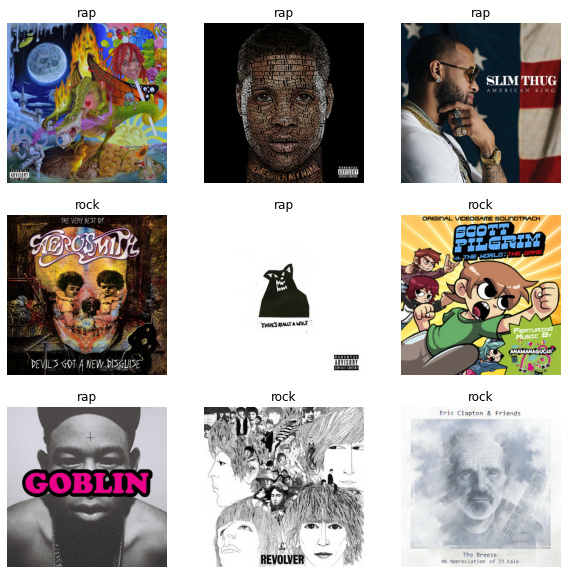

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Base Model

Start without transfer learning or drop out

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
89/89 [==============================] - 81s 897ms/step - loss: 0.6838 - accuracy: 0.6527 - val_loss: 0.5191 - val_accuracy: 0.7656
Epoch 2/5
89/89 [==============================] - 80s 894ms/step - loss: 0.5198 - accuracy: 0.7801 - val_loss: 0.4747 - val_accuracy: 0.8040
Epoch 3/5
89/89 [==============================] - 108s 1s/step - loss: 0.4005 - accuracy: 0.8421 - val_loss: 0.5089 - val_accuracy: 0.8011
Epoch 4/5
89/89 [==============================] - 288s 3s/step - loss: 0.2841 - accuracy: 0.8840 - val_loss: 0.7143 - val_accuracy: 0.7756
Epoch 5/5
89/89 [==============================] - 354s 4s/step - loss: 0.2581 - accuracy: 0.8989 - val_loss: 0.6285 - val_accuracy: 0.7656


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9

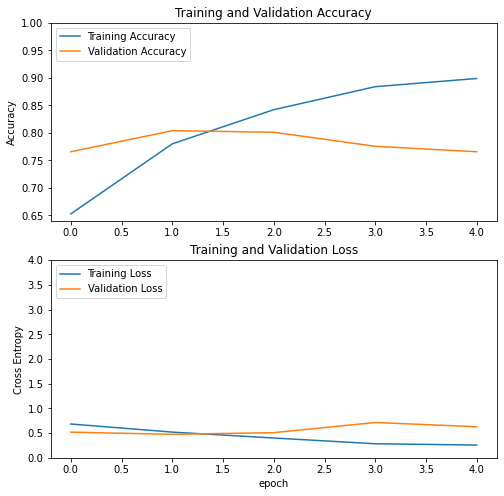

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)

In [32]:
y_prob = model.predict(val_ds)

22/22 [==============================] - 17s 723ms/step


In [33]:
y_predict = y_prob.argmax(axis=-1)

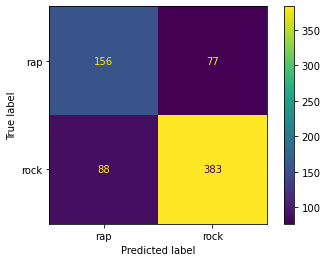

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()

Hmm Pretty bad :(, looks like we're overfitting a bit. Perhapps dropout can help.

### With Dropout added to our model

In [43]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.80, seed = 123),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [44]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [45]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
89/89 [==============================] - 498s 6s/step - loss: 0.6774 - accuracy: 0.6368 - val_loss: 0.5878 - val_accuracy: 0.6804
Epoch 2/10
89/89 [==============================] - 371s 4s/step - loss: 0.5841 - accuracy: 0.7265 - val_loss: 0.4896 - val_accuracy: 0.7969
Epoch 3/10
89/89 [==============================] - 290s 3s/step - loss: 0.5135 - accuracy: 0.7772 - val_loss: 0.4500 - val_accuracy: 0.8182
Epoch 4/10
89/89 [==============================] - 280s 3s/step - loss: 0.4850 - accuracy: 0.8035 - val_loss: 0.4462 - val_accuracy: 0.8168
Epoch 5/10
89/89 [==============================] - 249s 3s/step - loss: 0.4574 - accuracy: 0.8134 - val_loss: 0.4287 - val_accuracy: 0.8267
Epoch 6/10
89/89 [==============================] - 283s 3s/step - loss: 0.4135 - accuracy: 0.8244 - val_loss: 0.4264 - val_accuracy: 0.8253
Epoch 7/10
89/89 [==============================] - 255s 3s/step - loss: 0.3961 - accuracy: 0.8375 - val_loss: 0.4624 - val_accuracy: 0.8111
Epoch 8/10
89

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)       

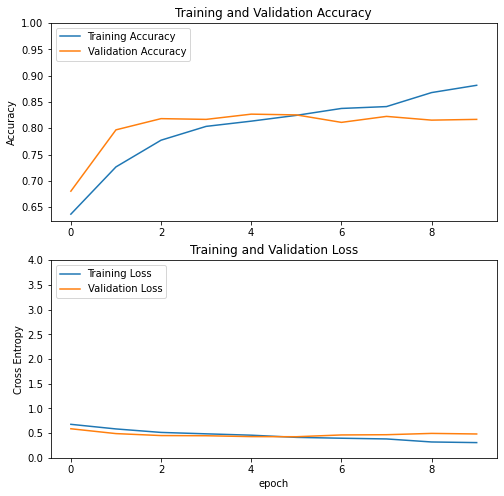

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [48]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

22/22 [==============================] - 14s 603ms/step


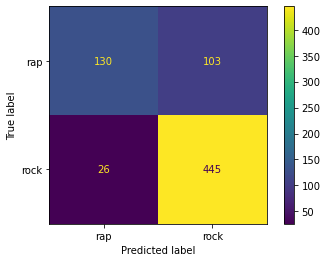

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()

### Transfer Learning

In [71]:
# Create the base model from the pre-trained model MobileNet V2

BATCH_SIZE = 32
IMG_SIZE = (300, 300)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [72]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [73]:
base_model.trainable = False

In [74]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 75, 75, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 77, 77, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 38, 38, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 38, 38, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 19, 19, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 19, 19, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 19, 19, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 19, 19, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 19, 19, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 19, 19, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 19, 19, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 19, 19, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 10, 10, 960)  8640       ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 10, 10, 960)  3840       ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 10, 10, 960)  0          ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 10, 10, 160)  153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [75]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [76]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation = 'relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [77]:
base_conainter = tf.keras.Sequential([])

In [78]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [79]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = base_conainter(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [80]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_4 (Sequential)   multiple                  0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                           

In [82]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_ds)

22/22 [==============================] - 16s 694ms/step - loss: 0.7685 - accuracy: 0.3878


In [83]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
89/89 [==============================] - 109s 1s/step - loss: 0.6863 - accuracy: 0.5140 - val_loss: 0.6504 - val_accuracy: 0.5625
Epoch 2/20
89/89 [==============================] - 109s 1s/step - loss: 0.6477 - accuracy: 0.5967 - val_loss: 0.6275 - val_accuracy: 0.6236
Epoch 3/20
89/89 [==============================] - 109s 1s/step - loss: 0.6302 - accuracy: 0.6332 - val_loss: 0.6123 - val_accuracy: 0.6449
Epoch 4/20
89/89 [==============================] - 107s 1s/step - loss: 0.6197 - accuracy: 0.6428 - val_loss: 0.6012 - val_accuracy: 0.6619
Epoch 5/20
89/89 [==============================] - 106s 1s/step - loss: 0.6111 - accuracy: 0.6690 - val_loss: 0.5898 - val_accuracy: 0.6875
Epoch 6/20
89/89 [==============================] - 106s 1s/step - loss: 0.6049 - accuracy: 0.6747 - val_loss: 0.5834 - val_accuracy: 0.6960
Epoch 7/20
89/89 [==============================] - 108s 1s/step - loss: 0.5937 - accuracy: 0.6885 - val_loss: 0.5772 - val_accuracy: 0.7116
Epoch 8/20
89

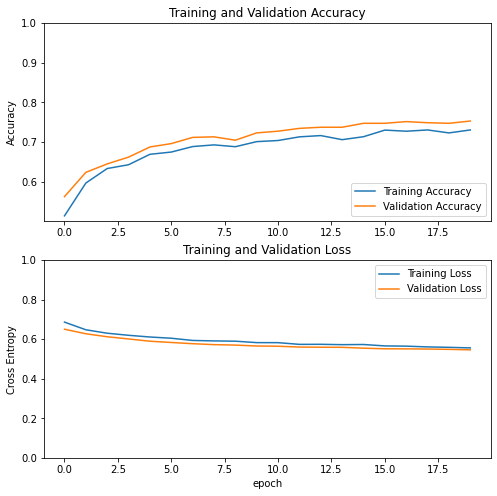

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

22/22 [==============================] - 26s 1s/step


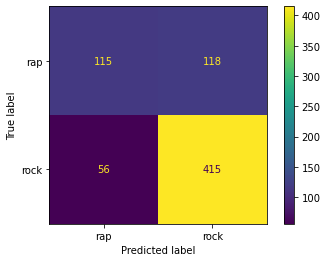

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()

### Fine Tuning

In [87]:
base_model.trainable = True

In [88]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [89]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [90]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_4 (Sequential)   multiple                  0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                           

In [91]:
len(model.trainable_variables)

56

In [93]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
89/89 [==============================] - 158s 2s/step - loss: 0.5545 - accuracy: 0.7322 - val_loss: 0.5290 - val_accuracy: 0.7741
Epoch 21/30
89/89 [==============================] - 151s 2s/step - loss: 0.5154 - accuracy: 0.7673 - val_loss: 0.5206 - val_accuracy: 0.7656
Epoch 22/30
89/89 [==============================] - 153s 2s/step - loss: 0.4867 - accuracy: 0.7847 - val_loss: 0.5193 - val_accuracy: 0.7741
Epoch 23/30
89/89 [==============================] - 157s 2s/step - loss: 0.4567 - accuracy: 0.8095 - val_loss: 0.5040 - val_accuracy: 0.7926
Epoch 24/30
89/89 [==============================] - 163s 2s/step - loss: 0.4349 - accuracy: 0.8276 - val_loss: 0.4963 - val_accuracy: 0.8196
Epoch 25/30
89/89 [==============================] - 160s 2s/step - loss: 0.4125 - accuracy: 0.8453 - val_loss: 0.5211 - val_accuracy: 0.7912
Epoch 26/30
89/89 [==============================] - 164s 2s/step - loss: 0.3916 - accuracy: 0.8595 - val_loss: 0.4807 - val_accuracy: 0.8281
Epoch 

In [94]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

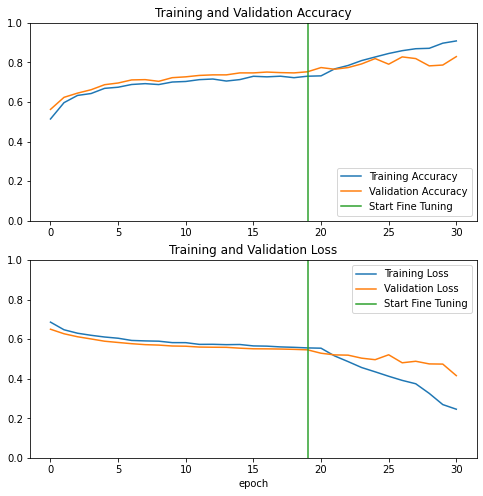

In [98]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

22/22 [==============================] - 23s 1s/step


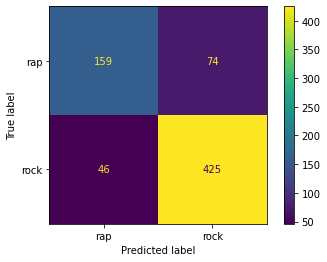

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()